In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import math
from math import sqrt
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset= pd.read_csv('/home/das.puj/ML_Project/ML_dataframe.csv',parse_dates= ['Date'],index_col=['Date'], encoding= 'latin1')
dataset= dataset['1915':'2014'].resample('M').mean()
dataset=pd.DataFrame( dataset.Precipitation)


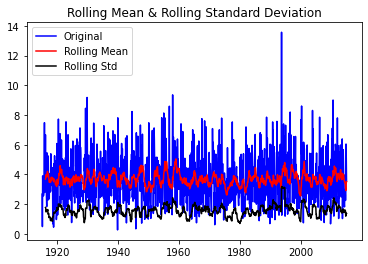

In [4]:
# Rolling Statistics

df = dataset
rolling_mean = df.rolling(window = 14).mean()
rolling_std = df.rolling(window = 14).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [6]:
# ADF Test -> null hypothesis = non-stationarity
# (hint: p-value is the probabiltiy that null hypothesis is true)

from statsmodels.tsa.stattools import adfuller

result = adfuller(dataset)
print('p-value: {}'.format(result[1]))

p-value: 0.0



 Autocorrelation



In [7]:
h_df_original=pd.DataFrame(dataset)

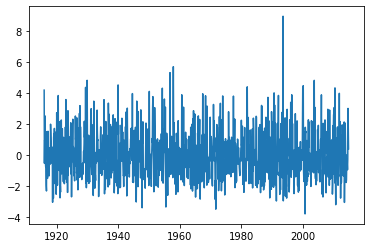

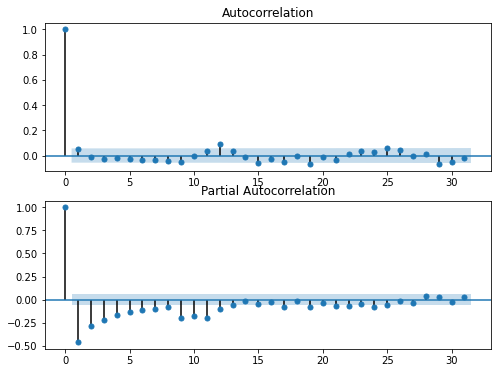

In [8]:
df_log = h_df_original.fillna(0)
df_log_stationary = df_log - df_log.rolling(window=10).mean()
plt.plot(df_log_stationary)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original time-series

fig, ax = plt.subplots(2, figsize=(8,6))
ax[0] = plot_acf(h_df_original, ax=ax[0])

# Calculate first-difference
df_log_stationary_diff = df_log_stationary - df_log_stationary.shift()
ax[1] = plot_pacf(df_log_stationary_diff.dropna(), ax=ax[1])

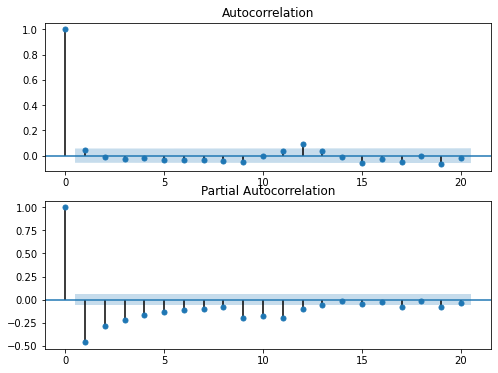

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the original time-series

fig, ax = plt.subplots(2, figsize=(8,6))
ax[0] = plot_acf(dataset, ax=ax[0], lags=20)

# Calculate first-difference
df_log_stationary_diff = df_log_stationary - df_log_stationary.shift()
ax[1] = plot_pacf(df_log_stationary_diff.dropna(), ax=ax[1], lags=20)


Finding the Best ARIMA Model


In [ ]:
from pmdarima import auto_arima 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(df_log_stationary_diff.dropna(), start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.40 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=5850.436, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5269.845, Time=0.61 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=3.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=5848.437, Time=0.11 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5534.734, Time=0.23 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5129.137, Time=1.62 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.55 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=5430.859, Time=1.63 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=4990.842, Time=2.00 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=5117.418, Time=0.93 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=9.84 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.48 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=4917.2

In [ ]:
df_data = df_log_stationary_diff

train = df_data.iloc[:len(df_data)-240] 
test = df_data.iloc[len(df_data)-240:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(df_data,  
                order = (3, 0, 0),  
                seasonal_order =(2, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

In [ ]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end).rename("Predictions") 
 
plt.rcParams.update({'figure.figsize': (10,5)}) #increase figure size
# plot predictions and actual values 

test = df_data.iloc[len(df_data)-240:]
test.plot(label= 'Truth')
predictions.plot(label= 'Prediction')  
plt.legend()
plt.show()

In [ ]:
print('MSE: ', metrics.mean_squared_error(test, predictions))
print('MAE: ', metrics.mean_absolute_error(test, predictions))
print('R2: ', metrics.r2_score(test, predictions))
#print('Correlation: ', stats.pearsonr(test, predictions)[0])
print('RMSLE: ',metrics.mean_squared_log_error(np.absolute(test), np.absolute(predictions)))
print('MAPE: ',metrics.mean_absolute_percentage_error(test, predictions))